In [1]:
import os
import glob
import pandas as pd
import numpy as np
import librosa
import random
import time 
import pickle
import queue
import threading

from tqdm import tqdm

from scipy import signal
from scipy.spatial.distance import squareform

from librosa.display import specshow, waveplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt

import IPython.display as ipd

import gc

# from umap import UMAP

np.random.seed(42)

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, Input, BatchNormalization, CuDNNLSTM
from keras.layers import Conv1D,MaxPooling1D , GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from keras.models import Model, load_model
from keras.callbacks import Callback, EarlyStopping
from keras.metrics import top_k_categorical_accuracy

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [26]:
test_song = "F:\\Nicolas\\PycharmProjects\\machine_learning\\audio\\FMA\\fma_small\\000\\000002.mp3"
base_song_path = "fma_small/000/000002.mp3"

In [27]:
y, sr = librosa.load(base_song_path, sr=None, mono = True)

if sr != 44100:
    y = librosa.resample(y, sr, 44100)
    sr = 44100
    
mfcc = librosa.feature.mfcc(y=y, 
                            sr=sr,
                            n_mfcc = 128,
                            n_fft = 2048, 
                            hop_length = 2048, # hop_length = 20 ms
#                             win_length = 2048,
#                             window = signal.tukey(2048),
                           )

X = librosa.power_to_db(mfcc)

# X -= X.min(axis=1)
# X /= X.max(axis=1)

X1 = (X - X.min(axis=1).reshape(-1, 1)) / (X.max(axis=1).reshape(-1, 1) - X.min(axis=1).reshape(-1, 1))
X2 = X - X.min()
X2 /= X2.max()
X2.shape

(128, 646)

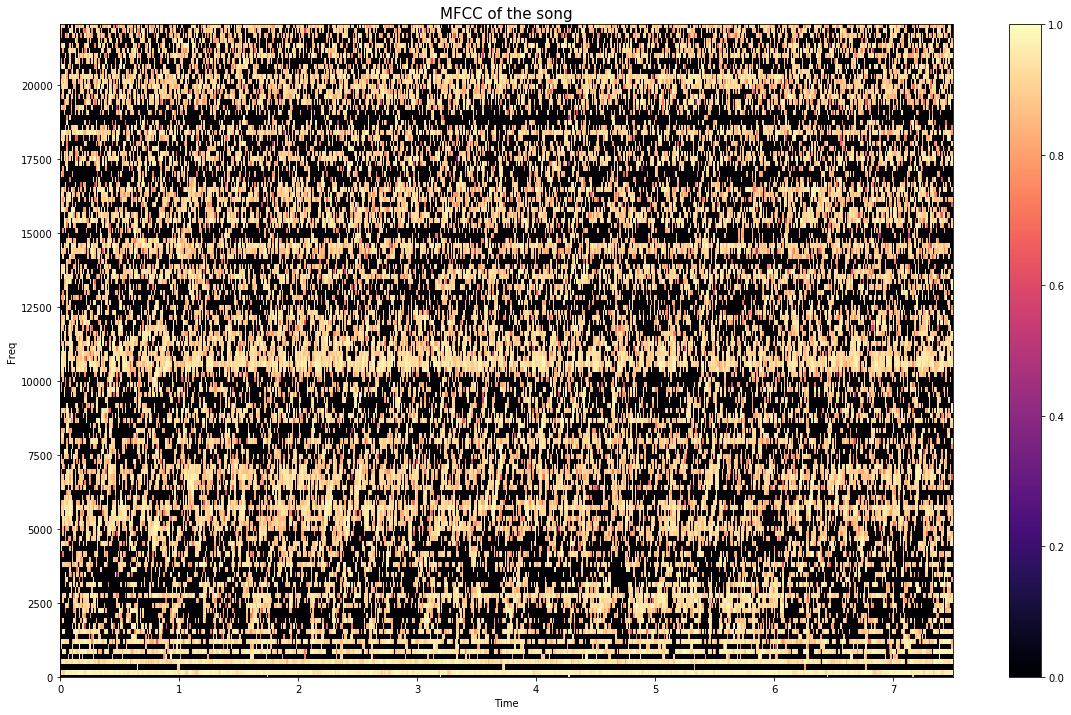

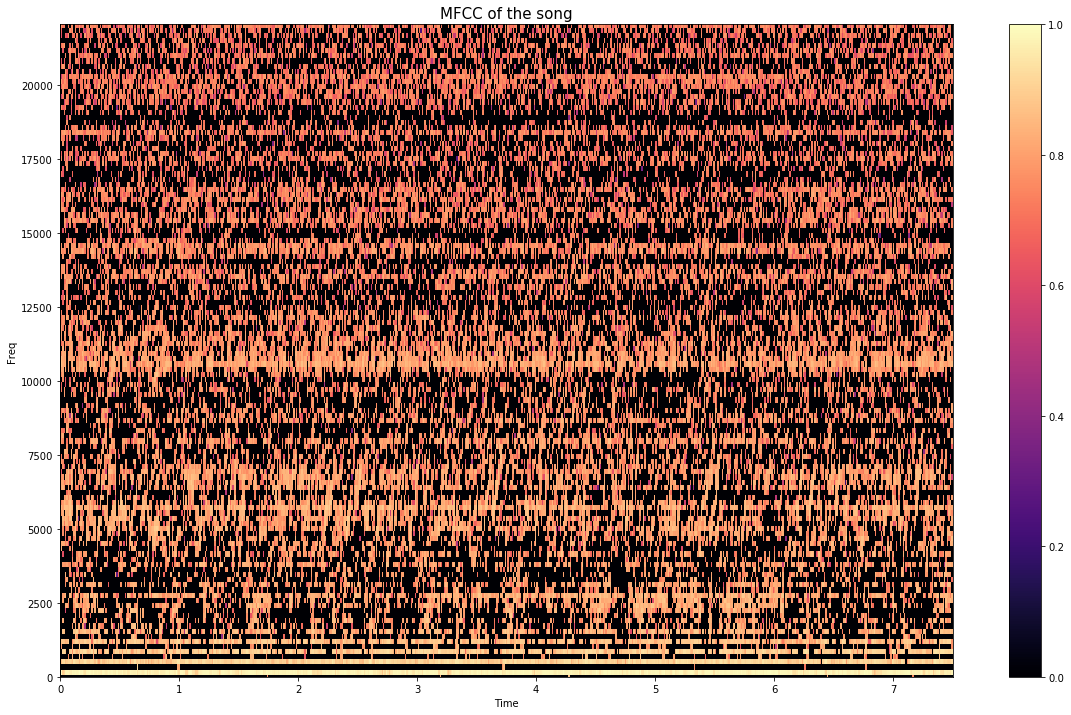

In [28]:
plt.figure(figsize=(20, 12))
librosa.display.specshow(X1, sr=sr, x_axis='time', y_axis='hz')
plt.ylabel("Freq")
plt.xlabel("Time")
plt.title("MFCC of the song", fontsize=15)
plt.colorbar()
plt.show()

plt.figure(figsize=(20, 12))
librosa.display.specshow(X2, sr=sr, x_axis='time', y_axis='hz')
plt.ylabel("Freq")
plt.xlabel("Time")
plt.title("MFCC of the song", fontsize=15)
plt.colorbar()
plt.show()

# Extraction

In [25]:
def extract_mfcc(input_path):
    y, sr = librosa.load(input_path, sr=None, mono = True)

    if sr != 44100:
        y = librosa.resample(y, sr, 44100)
        sr = 44100

    mfcc = librosa.feature.mfcc(y=y, 
                                sr=sr,
                                n_mfcc = 128,
                                n_fft = 2048, 
                                hop_length = 2048, # hop_length = 20 ms
                               )
    
    return librosa.power_to_db(mfcc)

for audio_path in tqdm(glob.glob(os.path.join("fma_small/*/*.mp3"))):
    filename = os.path.basename(audio_path)[:-4]
    output_path = os.path.join("preprocessed_audio", "MFCC_full", filename+".npy")
    if not os.path.exists(output_path):
        mfcc = extract_mfcc(audio_path)
        mfcc = mfcc[:, :640]
        mfcc -= mfcc.min()
        mfcc /= (mfcc.max()+1e-6)
        np.save(output_path, mfcc.astype(np.float16))

100%|██████████████████████████████████████████████████████████████████████████████| 7994/7994 [27:34<00:00,  4.83it/s]


# Models

In [3]:
def top1(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)

def top2(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top3(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top4(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=4)

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.epoch_time_start = time.time()
        self.times = []
        self.losses = []
        self.val_losses = []
        self.top1 = []
        self.top2 = []
        self.top3 = []
        self.top4 = []
        self.val_top1 = []
        self.val_top2 = []
        self.val_top3 = []
        self.val_top4 = []
        
    def on_epoch_end(self, batch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_top1.append(logs.get('val_top1'))
        self.val_top2.append(logs.get('val_top2'))
        self.val_top3.append(logs.get('val_top3'))
        self.val_top4.append(logs.get('val_top4'))
    
    def on_batch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        self.losses.append(logs.get('loss'))
        self.top1.append(logs.get('top1'))
        self.top2.append(logs.get('top2'))
        self.top3.append(logs.get('top3'))
        self.top4.append(logs.get('top4'))
        
    def convert_to_dict(self):
        return {
            "time" : self.times,
            "loss" : self.losses,
            "val_loss" : self.val_losses,
            "top1" : self.top1,
            "val_top1" : self.val_top1,
            "top2" : self.top2,
            "val_top2" : self.val_top2,
            "top3" : self.top3,
            "val_top3" : self.val_top3,
            "top4" : self.top4,
            "val_top4" : self.val_top4,
        }

In [4]:
label = pd.read_csv("preprocessed_meta/classes.csv", index_col = 0)

X = label.index.values

enc = LabelBinarizer()
y_enc = enc.fit_transform(label.title.values.reshape(-1, 1))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42)

NB_IMAGES_TRAIN = X_train.shape[0]
NB_IMAGES_TEST = X_test.shape[0]
N, H, W, L = 7994, 128, 640, 1
NB_CLASSES = 8
BATCH_SIZE = 10
EPOCHS  = 100

params_conv = {
    "kernel_size" : 4, 
    "strides" : 1,
    "activation" : 'relu',
    "padding" : 'same',
    "kernel_initializer" : "he_normal", 
    "bias_initializer" : "zeros", 
    "kernel_regularizer" : None
}

params_max_pool = {
    "pool_size" : 2
}

def batch_generator(idx_audio_list, classe, batch_size = 64):
#     batch_features = np.zeros((batch_size, H, W, L))
    batch_features = np.zeros((batch_size, H, W))
    batch_labels = np.zeros((batch_size, 8))
    while True:
        for i in range(batch_size):
            index = np.random.choice(len(idx_audio_list), 1)
            idx_audio = idx_audio_list[index]
            file_path = os.path.join("preprocessed_audio", "MFCC_full", "{0:06d}".format(idx_audio[0]) + ".npy")
#             print(np.load(file_path).reshape(H, W, 1).shape)
            batch_features[i] = np.load(file_path)#.reshape(H, W, 1)
            batch_labels[i] = classe[index]
        batch_features = batch_features.astype(np.float32)
        batch_labels = batch_labels.astype(np.float32)
        batch_features -= batch_features.min()
        batch_features /= batch_features.max()
        yield np.swapaxes(batch_features,1,2), batch_labels
        
train_generator = batch_generator(X_train, y_train, BATCH_SIZE)
test_generator = batch_generator(X_test, y_test, BATCH_SIZE)

In [11]:
inputs = Input((640, 128))

c1 = Conv1D(256, **params_conv) (inputs)
p1 = MaxPooling1D(pool_size = 4) (c1)

c2 = Conv1D(256, **params_conv) (p1)
p2 = MaxPooling1D(pool_size = 2) (c2)

c3 = Conv1D(256, **params_conv) (p2)
p3 = MaxPooling1D(pool_size = 2) (c3)

c4 = Conv1D(512, **params_conv) (p3)

g1 = GlobalMaxPooling1D() (c4)
g2 = GlobalAveragePooling1D() (c4)

f = Concatenate(axis=-1) ([g1, g2])

# f = Flatten() (g)

d1 = Dense(100, activation='relu') (f)
d1 = Dropout(0.4) (d1)

d2 = Dense(30, activation='relu') (d1)
d2 = Dropout(0.2) (d2)

outputs = Dense(NB_CLASSES, activation='softmax') (d2)

model = Model(inputs=[inputs], outputs=[outputs])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 640, 128)     0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 640, 256)     131328      input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 160, 256)     0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 160, 256)     262400      max_pooling1d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics = ["binary_crossentropy", top1, top2, top3, top4])

In [13]:
time_callback = TimeHistory()

model.fit_generator(generator = train_generator,
                    steps_per_epoch = NB_IMAGES_TRAIN//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps = NB_IMAGES_TEST//BATCH_SIZE,
                    verbose=2,
                    callbacks=[time_callback]
                    )

Epoch 1/100
 - 11s - loss: 0.3780 - binary_crossentropy: 0.3780 - top1: 0.1311 - top2: 0.2554 - top3: 0.3787 - top4: 0.5014 - val_loss: 0.3769 - val_binary_crossentropy: 0.3769 - val_top1: 0.1491 - val_top2: 0.2522 - val_top3: 0.3975 - val_top4: 0.5189
Epoch 2/100
 - 10s - loss: 0.3768 - binary_crossentropy: 0.3768 - top1: 0.1310 - top2: 0.2606 - top3: 0.3858 - top4: 0.5103 - val_loss: 0.3770 - val_binary_crossentropy: 0.3770 - val_top1: 0.1063 - val_top2: 0.2314 - val_top3: 0.3585 - val_top4: 0.4855
Epoch 3/100
 - 10s - loss: 0.3767 - binary_crossentropy: 0.3767 - top1: 0.1363 - top2: 0.2606 - top3: 0.3862 - top4: 0.5039 - val_loss: 0.3773 - val_binary_crossentropy: 0.3773 - val_top1: 0.0994 - val_top2: 0.2182 - val_top3: 0.3472 - val_top4: 0.4937
Epoch 4/100
 - 10s - loss: 0.3768 - binary_crossentropy: 0.3768 - top1: 0.1319 - top2: 0.2590 - top3: 0.3890 - top4: 0.5091 - val_loss: 0.3775 - val_binary_crossentropy: 0.3775 - val_top1: 0.0937 - val_top2: 0.2107 - val_top3: 0.3352 - val_t

Epoch 34/100
 - 10s - loss: 0.3768 - binary_crossentropy: 0.3768 - top1: 0.1302 - top2: 0.2588 - top3: 0.3861 - top4: 0.5138 - val_loss: 0.3769 - val_binary_crossentropy: 0.3769 - val_top1: 0.1277 - val_top2: 0.2572 - val_top3: 0.3692 - val_top4: 0.4862
Epoch 35/100
 - 10s - loss: 0.3767 - binary_crossentropy: 0.3767 - top1: 0.1296 - top2: 0.2579 - top3: 0.3911 - top4: 0.5138 - val_loss: 0.3773 - val_binary_crossentropy: 0.3773 - val_top1: 0.1233 - val_top2: 0.2384 - val_top3: 0.3535 - val_top4: 0.4679
Epoch 36/100
 - 10s - loss: 0.3769 - binary_crossentropy: 0.3769 - top1: 0.1221 - top2: 0.2502 - top3: 0.3714 - top4: 0.4981 - val_loss: 0.3771 - val_binary_crossentropy: 0.3771 - val_top1: 0.1151 - val_top2: 0.2170 - val_top3: 0.3321 - val_top4: 0.4604
Epoch 37/100
 - 10s - loss: 0.3766 - binary_crossentropy: 0.3766 - top1: 0.1341 - top2: 0.2640 - top3: 0.3937 - top4: 0.5208 - val_loss: 0.3771 - val_binary_crossentropy: 0.3771 - val_top1: 0.1296 - val_top2: 0.2585 - val_top3: 0.3604 - v

Epoch 67/100
 - 10s - loss: 0.3768 - binary_crossentropy: 0.3768 - top1: 0.1250 - top2: 0.2532 - top3: 0.3797 - top4: 0.5055 - val_loss: 0.3772 - val_binary_crossentropy: 0.3772 - val_top1: 0.1057 - val_top2: 0.2365 - val_top3: 0.3497 - val_top4: 0.4711
Epoch 68/100
 - 10s - loss: 0.3768 - binary_crossentropy: 0.3768 - top1: 0.1233 - top2: 0.2523 - top3: 0.3854 - top4: 0.5052 - val_loss: 0.3773 - val_binary_crossentropy: 0.3773 - val_top1: 0.1101 - val_top2: 0.2119 - val_top3: 0.3270 - val_top4: 0.4572
Epoch 69/100
 - 10s - loss: 0.3768 - binary_crossentropy: 0.3768 - top1: 0.1244 - top2: 0.2444 - top3: 0.3770 - top4: 0.5053 - val_loss: 0.3770 - val_binary_crossentropy: 0.3770 - val_top1: 0.1182 - val_top2: 0.2327 - val_top3: 0.3409 - val_top4: 0.4516
Epoch 70/100
 - 10s - loss: 0.3768 - binary_crossentropy: 0.3768 - top1: 0.1299 - top2: 0.2576 - top3: 0.3778 - top4: 0.5061 - val_loss: 0.3773 - val_binary_crossentropy: 0.3773 - val_top1: 0.0855 - val_top2: 0.1868 - val_top3: 0.3226 - v

KeyboardInterrupt: 

In [ ]:
with open('training_model_4.pkl', 'wb') as file:
    pickle.dump(time_callback.convert_to_dict(), file)